Transformer及其衍生架构，在自然语言处理上取得了卓越的成果。但是，在将这一范式迁移到时间序列预测上来的时候，却遇到了尴尬的打不过线性模型的困难

首先我们分析一下，NLP（自然语言处理）和TSF（时间序列预测）两个问题的主要差别：

1. 自然语言中的语义既存在在每个单词中，也存在在单词之间的序列关系上。一个句子完全打乱单词顺序，也能保留部分信息（尽管不那么准确）。一个还不懂语法的语言学习者，仅靠单词也可以和其他人勉强交流。但是对于时间序列，打乱顺序就意味着完全丢失信息，可以说时间序列的信息绝大部分都隐藏在序列之中。

2. 自然语言的具有高度的一致性和可迁移性，常见单词和词组的含义在绝大多数语料中都是相近相似的，虽然会有一些多义词但毕竟是少数。而不同的时间序列即使出现了相同的形态，也不能说就有相似含义。例如，在金融领域，某些价格形态会包含价格趋势信息，其底层的逻辑是多空双方的博弈导致的，但是如果这样的形态出现在例如气温序列中，就不能说表示趋势性，因为底层的逻辑完全不一样。

3. 自然语言的训练集非常丰富，在人类历史上积累了大量的训练语料。但由于时间序列的含义差距，每个领域的时间序列是有限的，只能使用当前研究的框架内的数据。一般资产的数据有10年以上已经是非常丰富的历史了。如果扩展序列就会面临结构和范式的变化。

4. 自然语言的模式迁移非常缓慢，几乎可以忽略不记，虽然人类的语言会有所发展和变化，但是这种变化都是以数十年为单位的，在短期内改变的只会有少数词的词义，大的语法是不会改变的。但对于金融数据。概念漂移是非常常见的，时间序列的底层因素，例如次贷危机、疫情的出现很可能直接导致资产的模式完全改变，从而让历史数据的价值大打折扣，进一步加剧了数据量的问题。

Transformer架构能在NLP上取得成功的原因，恰恰也是Transformer架构不能被直接迁移到TSF上的原因：

1. RNN架构的顺序结构会影响长距离信息传递，长距离信息要么随着梯度消失，要么产生梯度爆炸。为了能顺利捕捉长距离关系，Transformer架构可以放弃了RNN架构的顺序性，转而使用并行性保护远距离信息可以顺利传播；

2. 因为采用了并行架构丢失了顺序信息，Transformer架构采用位置编码补齐丢失的顺序信息。但位置编码会影响一部分原始语义信息；

3. 因为训练语料足够丰富，导致位置编码的影响可以被最小化；

4. 平行架构也可以充分运用算力，大幅度加速训练过程，因此可以接受更复杂的模型层数。将牺牲的部分通过更大的模型来弥补。

换言之，因为自然语言的训练资料足够丰富，足以掩盖Transformer架构的缺点，充分发挥Transformer架构的优势，才使得Transformer架构得以在NLP问题上大放异彩。但反过来，在TSF问题上，Transformer架构并没有这样的优势。而其劣势，会被时间序列数据量缺乏的问题放大。Transformer架构本身就很复杂，模型的参数量越大，需要的数据集也就越大，超大的模型可以轻松记忆本就为数不多的数据集导致过拟合，必须对扩展模型保持谨慎态度。

当然，这也并不意味着完全就不能使用Transformer架构。Transformer架构在长距离提取上仍然有优势。具体来说，如果想要充分发挥Transformer架构的优势，我们需要解决如下问题：

1. 每个信息单元包含的信息要足够丰富。自然语言中每个单词的语义已经非常丰富，最新的的大语言模型单个词嵌入维度已经达到了4096甚至更高。而单个时间步的OHLCV数据的维度太小，即使扩展一些辅助信息，也很难从单个时间步得到有效信息进行相互传播。因此，单个信息单元要从时间步提升到子序列级别，比如一个长达10天的子序列，除了10天本身的价格信息以外，还能抽象出某种趋势信息，例如一小段缩量上涨、或者一小段区间的放量震荡等等。通过将多个时间步组合成一个patch的方式，模型可以变为处理一段一段的时间。同时，这样的结构也可以接入更长的历史窗口，绕开Transformer在注意力层的O(N^2)复杂度的限制。

2. 用科学的方式扩展训练集，如果我们的目标是资产价格预测，那么至少训练集的范围可以扩展到其他金融资产，但不应该扩展到非金融的领域。因为价格的底层逻辑是供需关系、多空博弈。同时，还要增加额外的机制让模型理解不同资产之间的差距和联系，例如波动率、相关性、协整性等等。



In [1]:
import os
os.chdir('d:/future/Index_Future_Prediction')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tqdm
import optuna

import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.optim import lr_scheduler, Adam, AdamW
from torch.utils.data import TensorDataset, DataLoader

from utils import *

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

In [2]:
import math
class PositionalEncoding(nn.Module):
    """
    处理(* , seq_len, feature_dim) tensor，在seq_len维度上添加位置编码。
    """
    def __init__(self, d_model, dropout, max_len = 5000):
        """
            d_model (int): 特征维度 (feature_dim)
            dropout (float): Dropout的概率
            max_len (int): 预先计算编码的最大序列长度
        """
        super().__init__()
        self.dropout = nn.Dropout(dropout)
        assert d_model % 2 == 0, "d_model 必须是偶数"

        position = torch.arange(max_len).unsqueeze(1)


        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, d_model)
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        self.register_buffer('pe', pe)

    def forward(self, x):
        seq_len = x.size(-2)
        pos_encoding = self.pe[:seq_len, :]
        x = x + pos_encoding
        return self.dropout(x)
    
class PatchProjection(nn.Module):
    def __init__(self, input_size, patch_size, d_model = 128, dropout = 0.1):
        super().__init__()
        self.input_size = input_size
        self.patch_size = patch_size
        
        self.project = nn.Linear(input_size * patch_size, d_model) # 暂时只使用单层线性投影就够了 暂时不需要做太过深度的信息抽象，这个过程会交给Encoder去完成
        self.pe = PositionalEncoding(d_model = d_model, dropout = dropout)
        
    
    def forward(self, x):
        x = self.project(x)
        x = self.pe(x)
        return x

In [3]:
from modules.patch import TimeSeriesPatcher
from modules.encoder import MultiLayerEncoder


class Patch_TST(nn.Module):
    """Patch Time Series Transformer"""
    def __init__(self, input_size, seq_len, patch_size, stride, num_layer, num_head, d_model, masking_ratio, mask_expand_size, dropout_1, dropout_2, dropout_3):
        super().__init__()
        self.device = 'cuda:0'
        self.input_size = input_size
        self.patch_size = patch_size
        self.stride = stride
        self.masking_ratio = masking_ratio
        self.mask_expand_size = mask_expand_size

        self.num_patch = int(np.floor((seq_len - patch_size) / stride) + 1)

        self.patch = TimeSeriesPatcher(patch_size, stride) # 首先经过patcher分成子序列

        self.projection = PatchProjection(input_size, patch_size, d_model = d_model, dropout = dropout_1)

        self.encoder = MultiLayerEncoder(dim_feature = d_model, dim_sequence = self.num_patch, num_enc_layer = num_layer, num_head = num_head, num_ffn_hidden = d_model*2, dropout = dropout_2)

        self.reconstruction = nn.Linear(d_model, input_size * patch_size)
        
        self.output = nn.Sequential(
            nn.Flatten(start_dim = -2),
            nn.Dropout(dropout_3),
            HybridDecoder(dim_state = self.num_patch * d_model, init_prob = [0.0,0.5,0.0])
        )
    
    def self_supervised(self, x):
        """
        自监督预训练
        如果不允许patch重叠，正好被patch隔断的形态无法学习到。
        允许patch重叠，则模型预训练的时候可以从前后patch偷看到信息。
        需要用双重mask
        target mask 是真正需要重建的patch
        input mask 是target mask的扩展，根据系数向两侧扩展掩蔽范围。例如假如patch允许重叠50%，则向前后各多屏蔽一个patch就可以完全屏蔽掉信息。
        """
        device = x.device
        batch_size = x.shape[0]


        noise = torch.rand(size=(batch_size, self.num_patch), device=device)
        target_mask = noise < self.masking_ratio
        
        # 防止出现所有 patch 都没被 mask 的情况，至少 mask 一个随机选择一个 patch 进行 mask
        if not target_mask.any(dim=1).all():
            for i in range(batch_size):
                if not target_mask[i].any():
                    fallback_idx = torch.randint(0, self.num_patch, (1,)).item()
                    target_mask[i, fallback_idx] = True

        target_mask_float = target_mask.float().unsqueeze(1)
        kernel_size = 2 * self.mask_expand_size + 1
        kernel = torch.ones(1, 1, kernel_size, device=device)
        padding = self.mask_expand_size
        expanded_mask_float = F.conv1d(target_mask_float, kernel, padding=padding)
        input_mask = (expanded_mask_float > 0).squeeze(1)


        x_patched = self.patch(x)
        reshape_mask = input_mask.unsqueeze(-1)
        x_masked = torch.where(reshape_mask, 0.0, x_patched)
        x_projected = self.projection(x_masked)
        x_encodered = self.encoder(x_projected)
        
        x_pre_reconstruction = x_encodered[target_mask] # 仅关注target mask
        x_reconstructed = self.reconstruction(x_pre_reconstruction)
        x_target = x_patched[target_mask] # 仅关注target mask

        return x_reconstructed, x_target
    
    def forward(self, x):
        """前向传播输出"""
        x_patched = self.patch(x)
        x_projected = self.projection(x_patched)
        x_encodered = self.encoder(x_projected)
        output = self.output(x_encodered)
        return output
        


stride = patch_size // 2 # 50 overlap
masking_ratio = 0.75 # 模型可以从前后patch偷看信息，因此必须提高遮蔽率来抑制这种偷看

最佳准确率:  0.4144319490840037
最佳超参数:  {'seq_len': 30, 'patch_size': 5, 'num_layer': 3, 'num_head': 4, 'd_model': 256, 'dropout_1': 0.27149005025784373, 'dropout_2': 0.482387240118911, 'batch_size': 256, 'learning_rate': 0.000985487230271521, 'assets_list': ['IH.CFX', 'IF.CFX', 'IC.CFX']}

最佳准确率:  0.3711612921370112
最佳超参数:  {'seq_len': 118, 'patch_size': 5, 'num_layer': 3, 'num_head': 4, 'd_model': 256, 'dropout_1': 0.4818863873957155, 'dropout_2': 0.0203014150393781, 'batch_size': 64, 'learning_rate': 0.0008700348124440109, 'assets_list': ['IH.CFX', 'IF.CFX', 'IC.CFX']}

In [4]:
def objective(trial):

    # 超参数
    seq_len = trial.suggest_int("seq_len", 120, 250)
    patch_size = 5
    # patch_size = trial.suggest_int("patch_size", 3,7)


    num_layer = trial.suggest_categorical('num_layer', [3,4,5])
    num_head = trial.suggest_categorical('num_head', [4,8,16])
    d_model = trial.suggest_categorical('d_model', [128, 256, 512])
    

    dropout_1 = trial.suggest_float("dropout_1", 0.4, 0.6)
    dropout_2 = trial.suggest_float("dropout_2", 0.0, 0.1)
    dropout_3 = 0.2

    batch_size = trial.suggest_categorical('batch_size', [32, 64,128])
    learning_rate = trial.suggest_float("learning_rate", 1e-4, 1e-2, log=True)
    weight_decay = trial.suggest_float("weight_decay", 1e-6, 1e-3, log=True)

    assets_list_all = ['IH.CFX', 'IF.CFX', 'IC.CFX', 'AU.SHF', 'JM.DCE','RB.SHF','HC.SHF', 'I.DCE', 'M.DCE', 'CF.ZCE',]
    assets_list_cfx = ['IH.CFX', 'IF.CFX', 'IC.CFX',]
    assets_list = trial.suggest_categorical("assets_list", [assets_list_cfx])

    # 预训练目标 这两个超参数是比较特殊的，不能随机选择
    # 掩码的比例是预训练的难度，随机选择这个参数不公平
    # 步长则关系到模型能从前后的序列中偷看到多少的的信息，对预训练也至关重要
    
    # stride = patch_size # no overlap
    # masking_ratio = 0.2 # 可以设置较小的遮蔽率，因为模型完全不能偷看，只要遮蔽率是固定的，对其他超参数选择就是公平的

    stride = patch_size // 2 # 50 overlap
    masking_ratio = 0.2 # 模型可以从前后patch偷看信息，因此必须提高遮蔽率来抑制这种偷看
    mask_expand_size = 1

    # 提取数据
    feature_columns = ['inday_chg_open','inday_chg_high','inday_chg_low','inday_chg_close','inday_chg_amplitude', 'ma_10','ma_26','ma_45','ma_90','ma_vol',]
    label_columns = ['label_return','down_prob','middle_prob','up_prob']

    
    # 加载数据
    feature = []
    label = []
    for asset_code in assets_list:
        data = pd.read_csv(f'data/{asset_code}.csv')
        feature.append(torch.tensor(data[feature_columns].values, dtype = torch.float32, device = 'cuda:0'))
        label.append(torch.tensor(data[label_columns].values, dtype = torch.float32, device = 'cuda:0'))

    feature = torch.stack(feature, dim = 1)
    label = torch.stack(label, dim = 1)
    feature = feature.unfold(dimension = 0, size = seq_len, step = 1).transpose(2,3)
    label = label[seq_len-1:]
    data = RandomLoader(feature, label)
    train_loader, test_loader = data(batch_size=batch_size, slice_size=[0.5,0.4], balance=[True, False])



    loss_fn = nn.MSELoss()
    model = Patch_TST(input_size = 10,
                    seq_len = seq_len,
                    patch_size = patch_size,
                    stride = stride,
                    num_layer = num_layer, 
                    num_head = num_head,
                    d_model = d_model,
                    masking_ratio = masking_ratio,
                    mask_expand_size = mask_expand_size,
                    dropout_1 = dropout_1,
                    dropout_2 = dropout_2,
                    dropout_3 = dropout_3,
                    ).to('cuda:0')

    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay = weight_decay)
    scheduler = lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.95)


    def epoch():
        train_losses = []
        model.train()
        for batch_x, batch_y in train_loader:
            optimizer.zero_grad()
            x_reconstructed, x_target = model.self_supervised(batch_x)
            loss = loss_fn(x_reconstructed, x_target)
            train_losses.append(loss.item()) 
            loss.backward()
            optimizer.step()
        
        test_losses = []
        model.eval()
        with torch.no_grad():
            for batch_x, batch_y in test_loader:
                x_reconstructed, x_target = model.self_supervised(batch_x)
                loss = loss_fn(x_reconstructed, x_target)
                test_losses.append(loss.item()) 
        return np.mean(train_losses), np.mean(test_losses)

    def train(epochs = 100):
        train_losses = []
        test_losses = []
        for i in tqdm.tqdm(range(epochs)):
            train_loss, test_loss = epoch()
            train_losses.append(train_loss)
            test_losses.append(test_loss)
            scheduler.step()
        # plt.plot(range(epochs), train_losses)
        # plt.plot(range(epochs), test_losses)
        # plt.show()
        return np.mean(test_losses[-10:])

    final_loss = train(30)

    return final_loss

In [5]:
study = optuna.create_study(
    direction="minimize",
    study_name="patchtst_pretrain",
    storage="sqlite:///db.sqlite3_1",  # 保存到 SQLite 文件
    load_if_exists=True # 如果存在同名study，则加载它
)
study.optimize(objective, n_trials=30)


print("最佳试验的编号: ", study.best_trial.number)
print("最佳loss: ", study.best_value)
print("最佳超参数: ", study.best_params)
df = study.trials_dataframe()
df.sort_values(by='value')

[I 2025-10-05 03:53:23,662] Using an existing study with name 'patchtst_pretrain' instead of creating a new one.
100%|██████████| 30/30 [00:41<00:00,  1.37s/it]
[I 2025-10-05 03:54:06,237] Trial 2 finished with value: 0.4356943588124381 and parameters: {'seq_len': 172, 'num_layer': 5, 'num_head': 8, 'd_model': 256, 'dropout_1': 0.48398378399141273, 'dropout_2': 0.05849657638528469, 'batch_size': 64, 'learning_rate': 0.0003109979701758971, 'weight_decay': 1.0266651217234693e-06, 'assets_list': ['IH.CFX', 'IF.CFX', 'IC.CFX']}. Best is trial 2 with value: 0.4356943588124381.
100%|██████████| 30/30 [01:30<00:00,  3.03s/it]
[I 2025-10-05 03:55:37,422] Trial 3 finished with value: 0.43400625890942035 and parameters: {'seq_len': 122, 'num_layer': 5, 'num_head': 16, 'd_model': 512, 'dropout_1': 0.42335650333460906, 'dropout_2': 0.022184356998410117, 'batch_size': 32, 'learning_rate': 0.00010350579210628519, 'weight_decay': 0.00032211247590812974, 'assets_list': ['IH.CFX', 'IF.CFX', 'IC.CFX']}.

最佳试验的编号:  27
最佳准确率:  0.3679165592887899
最佳超参数:  {'seq_len': 164, 'num_layer': 4, 'num_head': 4, 'd_model': 512, 'dropout_1': 0.4904027601461599, 'dropout_2': 0.05173672499291169, 'batch_size': 32, 'learning_rate': 0.0004063346203116716, 'weight_decay': 0.0009988629575338828, 'assets_list': ['IH.CFX', 'IF.CFX', 'IC.CFX']}


,number,value,datetime_start,datetime_complete,duration,params_assets_list,params_batch_size,params_d_model,params_dropout_1,params_dropout_2,params_learning_rate,params_num_head,params_num_layer,params_seq_len,params_weight_decay,state
27,27,0.367917,2025-10-05 04:16:39.321003,2025-10-05 04:17:45.680688,0 days 00:01:06.359685,"[IH.CFX, IF.CFX, IC.CFX]",32,512,0.490403,0.051737,0.000406,4,4,164,0.000999,COMPLETE
25,25,0.380080,2025-10-05 04:14:25.904459,2025-10-05 04:15:34.230865,0 days 00:01:08.326406,"[IH.CFX, IF.CFX, IC.CFX]",32,512,0.516069,0.048464,0.000375,4,4,144,0.000378,COMPLETE
26,26,0.383939,2025-10-05 04:15:34.243046,2025-10-05 04:16:39.308877,0 days 00:01:05.065831,"[IH.CFX, IF.CFX, IC.CFX]",32,256,0.514821,0.051445,0.000808,4,4,167,0.000394,COMPLETE
28,28,0.390250,2025-10-05 04:17:45.692278,2025-10-05 04:19:00.298819,0 days 00:01:14.606541,"[IH.CFX, IF.CFX, IC.CFX]",32,512,0.494189,0.053919,0.000416,4,4,165,0.000918,COMPLETE
23,23,0.392749,2025-10-05 04:12:02.628212,2025-10-05 04:13:13.967289,0 days 00:01:11.339077,"[IH.CFX, IF.CFX, IC.CFX]",32,512,0.446678,0.046300,0.000189,4,4,132,0.000190,COMPLETE
6,6,0.399334,2025-10-05 03:58:22.325816,2025-10-05 03:59:43.983017,0 days 00:01:21.657201,"[IH.CFX, IF.CFX, IC.CFX]",32,256,0.514009,0.081415,0.000886,4,5,188,0.000050,COMPLETE
8,8,0.401458,2025-10-05 04:00:23.979674,2025-10-05 04:00:58.237122,0 days 00:00:34.257448,"[IH.CFX, IF.CFX, IC.CFX]",64,512,0.457095,0.040933,0.000174,16,4,133,0.000101,COMPLETE
24,24,0.405949,2025-10-05 04:13:13.979036,2025-10-05 04:14:25.892433,0 days 00:01:11.913397,"[IH.CFX, IF.CFX, IC.CFX]",32,512,0.438631,0.051493,0.000181,4,4,139,0.000266,COMPLETE
12,12,0.406024,2025-10-05 04:02:28.049058,2025-10-05 04:03:35.677189,0 days 00:01:07.628131,"[IH.CFX, IF.CFX, IC.CFX]",32,512,0.456448,0.044862,0.000115,4,4,121,0.000102,COMPLETE
31,31,0.406975,2025-10-05 04:20:31.652653,2025-10-05 04:21:43.070599,0 days 00:01:11.417946,"[IH.CFX, IF.CFX, IC.CFX]",32,256,0.551360,0.050124,0.000665,4,4,173,0.000929,COMPLETE


In [6]:
df = study.trials_dataframe()
df.to_csv('result.csv')
df.sort_values(by='value').head(10)

,number,value,datetime_start,datetime_complete,duration,params_assets_list,params_batch_size,params_d_model,params_dropout_1,params_dropout_2,params_learning_rate,params_num_head,params_num_layer,params_seq_len,params_weight_decay,state
27,27,0.367917,2025-10-05 04:16:39.321003,2025-10-05 04:17:45.680688,0 days 00:01:06.359685,"[IH.CFX, IF.CFX, IC.CFX]",32,512,0.490403,0.051737,0.000406,4,4,164,0.000999,COMPLETE
25,25,0.380080,2025-10-05 04:14:25.904459,2025-10-05 04:15:34.230865,0 days 00:01:08.326406,"[IH.CFX, IF.CFX, IC.CFX]",32,512,0.516069,0.048464,0.000375,4,4,144,0.000378,COMPLETE
26,26,0.383939,2025-10-05 04:15:34.243046,2025-10-05 04:16:39.308877,0 days 00:01:05.065831,"[IH.CFX, IF.CFX, IC.CFX]",32,256,0.514821,0.051445,0.000808,4,4,167,0.000394,COMPLETE
28,28,0.390250,2025-10-05 04:17:45.692278,2025-10-05 04:19:00.298819,0 days 00:01:14.606541,"[IH.CFX, IF.CFX, IC.CFX]",32,512,0.494189,0.053919,0.000416,4,4,165,0.000918,COMPLETE
23,23,0.392749,2025-10-05 04:12:02.628212,2025-10-05 04:13:13.967289,0 days 00:01:11.339077,"[IH.CFX, IF.CFX, IC.CFX]",32,512,0.446678,0.046300,0.000189,4,4,132,0.000190,COMPLETE
6,6,0.399334,2025-10-05 03:58:22.325816,2025-10-05 03:59:43.983017,0 days 00:01:21.657201,"[IH.CFX, IF.CFX, IC.CFX]",32,256,0.514009,0.081415,0.000886,4,5,188,0.000050,COMPLETE
8,8,0.401458,2025-10-05 04:00:23.979674,2025-10-05 04:00:58.237122,0 days 00:00:34.257448,"[IH.CFX, IF.CFX, IC.CFX]",64,512,0.457095,0.040933,0.000174,16,4,133,0.000101,COMPLETE
24,24,0.405949,2025-10-05 04:13:13.979036,2025-10-05 04:14:25.892433,0 days 00:01:11.913397,"[IH.CFX, IF.CFX, IC.CFX]",32,512,0.438631,0.051493,0.000181,4,4,139,0.000266,COMPLETE
12,12,0.406024,2025-10-05 04:02:28.049058,2025-10-05 04:03:35.677189,0 days 00:01:07.628131,"[IH.CFX, IF.CFX, IC.CFX]",32,512,0.456448,0.044862,0.000115,4,4,121,0.000102,COMPLETE
31,31,0.406975,2025-10-05 04:20:31.652653,2025-10-05 04:21:43.070599,0 days 00:01:11.417946,"[IH.CFX, IF.CFX, IC.CFX]",32,256,0.551360,0.050124,0.000665,4,4,173,0.000929,COMPLETE


In [7]:
from optuna.visualization import plot_optimization_historyplot_param_importances

fig = plot_optimization_history(study)
fig.show()

In [8]:
from optuna.visualization import plot_param_importances

fig = plot_param_importances(study)
fig.show()

根据写死的最优参数更新保存模型
最佳准确率:  0.3711612921370112
最佳超参数:  {'seq_len': 118, 'patch_size': 5, 'num_layer': 3, 'num_head': 4, 'd_model': 256, 'dropout_1': 0.4818863873957155,
'dropout_2': 0.0203014150393781, 'batch_size': 64, 'learning_rate': 0.0008700348124440109, 'assets_list': ['IH.CFX', 'IF.CFX', 'IC.CFX']}

最佳超参数:  {'seq_len': 164, 'num_layer': 4, 'num_head': 4, 'd_model': 512, 'dropout_1': 0.4904027601461599, 'dropout_2': 0.05173672499291169,
'batch_size': 32, 'learning_rate': 0.0004063346203116716, 'weight_decay': 0.0009988629575338828, 'assets_list': ['IH.CFX', 'IF.CFX', 'IC.CFX']}

100%|██████████| 50/50 [02:01<00:00,  2.43s/it]


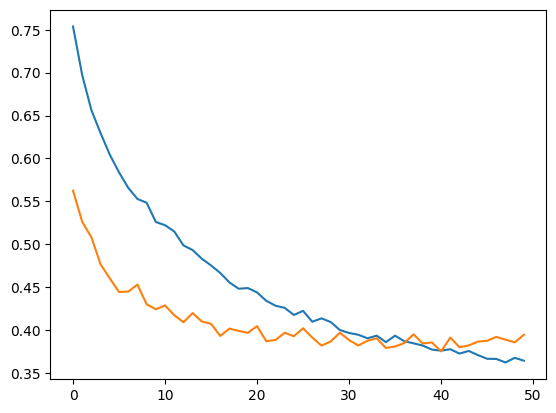

In [13]:
# 这些参数是两阶段共享的

seq_len = 160
patch_size = 5
num_layer = 4
num_head = 4
d_model = 256

assets_list = ['IH.CFX', 'IF.CFX', 'IC.CFX',]

stride = patch_size // 2 # 50% overlap
masking_ratio = 0.2 
mask_expand_size = 1


# 这些参数是可变的
batch_size = 32

dropout_1 = 0.5
dropout_2 = 0.05
dropout_3 = 0.2

learning_rate = 0.0004063346203116716
weight_decay = 0.0009988629575338828


# 提取数据
feature_columns = ['inday_chg_open','inday_chg_high','inday_chg_low','inday_chg_close','inday_chg_amplitude', 'ma_10','ma_26','ma_45','ma_90','ma_vol',]
label_columns = ['label_return','down_prob','middle_prob','up_prob']

feature = []
label = []
for asset_code in assets_list:
    data = pd.read_csv(f'data/{asset_code}.csv')
    feature.append(torch.tensor(data[feature_columns].values, dtype = torch.float32, device = 'cuda:0'))
    label.append(torch.tensor(data[label_columns].values, dtype = torch.float32, device = 'cuda:0'))

feature = torch.stack(feature, dim = 1)
label = torch.stack(label, dim = 1)
feature = feature.unfold(dimension = 0, size = seq_len, step = 1).transpose(2,3)
label = label[seq_len-1:]
data = RandomLoader(feature, label)
train_loader, test_loader = data(batch_size=batch_size, slice_size=[0.5,0.4], balance=[True, False])


loss_fn = nn.MSELoss()
model = Patch_TST(input_size = 10,
                    seq_len = seq_len,
                    patch_size = patch_size,
                    stride = stride,
                    num_layer = num_layer, 
                    num_head = num_head,
                    d_model = d_model,
                    masking_ratio = masking_ratio,
                    mask_expand_size = mask_expand_size,
                    dropout_1 = dropout_1,
                    dropout_2 = dropout_2,
                    dropout_3 = dropout_3,
                    ).to('cuda:0')

optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay = weight_decay)
scheduler = lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.95)


def epoch():
    train_losses = []
    model.train()
    for batch_x, batch_y in train_loader:
        optimizer.zero_grad()
        x_reconstructed, x_target = model.self_supervised(batch_x)
        loss = loss_fn(x_reconstructed, x_target)
        train_losses.append(loss.item()) 
        loss.backward()
        optimizer.step()
        
    test_losses = []
    model.eval()
    with torch.no_grad():
        for batch_x, batch_y in test_loader:
            x_reconstructed, x_target = model.self_supervised(batch_x)
            loss = loss_fn(x_reconstructed, x_target)
            test_losses.append(loss.item()) 
    return np.mean(train_losses), np.mean(test_losses)

def train(epochs = 30):
    train_losses = []
    test_losses = []
    for i in tqdm.tqdm(range(epochs)):
        train_loss, test_loss = epoch()
        train_losses.append(train_loss)
        test_losses.append(test_loss)
        scheduler.step()
    plt.plot(range(epochs), train_losses)
    plt.plot(range(epochs), test_losses)
    plt.show()
    return np.mean(test_losses[-10:])


train(50)
torch.save(model.state_dict(), 'params/self_supervised.params')